Generating Synthetic Images with GANS from Cancer Dataset 

In [ ]:
!pip install -U torch torchvision torchtext torchaudio --quiet
!pip install -U pytorch-lightning --quiet
!pip install -U opendatasets --upgrade --quiet

In [ ]:
import os,json, logging, zipfile, shutil
from pathlib import Path
import opendatasets as od, pandas as pd,  numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl
pd.__version__, np.__version__, torch.__version__, pl.__version__

('2.2.2', '1.26.4', '2.6.0+cu124', '2.5.0.post0')

In [ ]:
from google.colab import files
files.upload()

In [ ]:
DATA_PATH = Path('data')
KAGGLE_JSON = DATA_PATH/'kaggle.json'
IS_KAGGLE_KEY = KAGGLE_JSON.exists()
KAGGLE_API = None
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c histopathologic-cancer-detection
!unzip histopathologic-cancer-detection.zip

In [ ]:
'''
dataset_url = ''
od.download(dataset_url)
'''

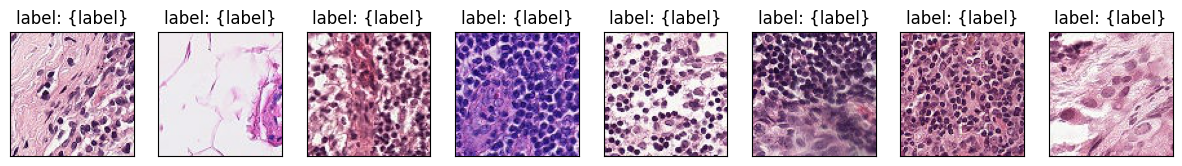

In [ ]:
cancer_labels = pd.read_csv('train_labels.csv')

np.random.seed(0)
train_imgs_lst = os.listdir('train')
selected_img_lst = []
for img in np.random.choice(train_imgs_lst, 10000):
  selected_img_lst.append(img)
fig = plt.figure(figsize=(15, 5))
for index, img in enumerate(np.random.choice(selected_img_lst, 8)):
  ax = fig.add_subplot(1, 8, index+1, xticks=[], yticks=[])
  img_n = Image.open('train/' +img)
  plt.imshow(img_n)
  label = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0],'label'].values[0]
  ax.set_title("label: {label}")

In [ ]:
np.random.seed(0)
train = np.random.shuffle(selected_img_lst)
transform = T.Compose([
    #T.Resize((64, 64)), T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    T.Resize((64, 64)), T.RandomHorizontalFlip(), T.RandomVerticalFlip(), T.ToTensor()])

In [ ]:
from PIL import Image as PilImage
class CancerDataset(Dataset):
  def __init__(self, data_folder,
               transform = T.Compose([T.CenterCrop(32),T.ToTensor()])):
    self.data_folder = data_folder
    self.list_image_files = [s for s in os.listdir(data_folder)]
    self.transform = transform

  def __len__(self):
    return len(self.list_image_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.data_folder, self.list_image_files[idx])
    image = PilImage.open(img_name)
    image = self.transform(image)
    img_name_short = self.list_image_files[idx].split('.')[0]


    return image

train_set = CancerDataset(data_folder='/content/train/',transform=transform)
#test_set = CancerDataset(data_folder='/content/test/',transform=transform)

In [ ]:
batch_size = 128

train_dataloader = DataLoader(
    train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
'''
test_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)
'''

'\ntest_dataloader = DataLoader(test_set, batch_size, num_workers=2, pin_memory=True)\n'

In [ ]:
''' channel first color images '''
image_1 = train_set[10]
image_1.shape,

(torch.Size([3, 64, 64]),)

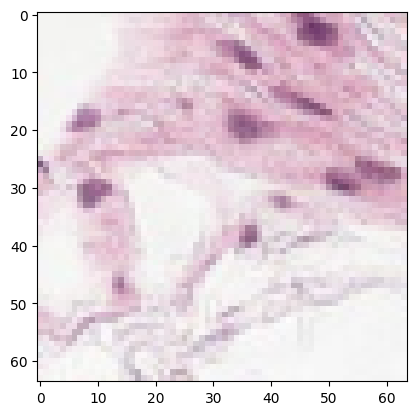

In [ ]:
plt.imshow(image_1.permute(1, 2, 0))

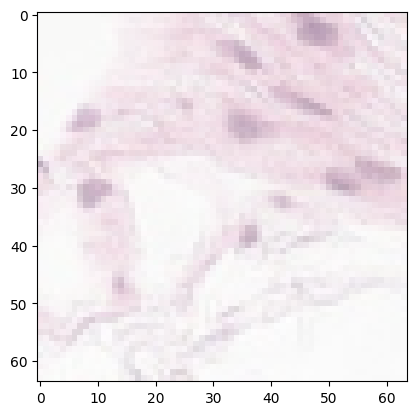

In [ ]:
plt.imshow(image_1.permute(1, 2, 0)*0.5 +0.5)

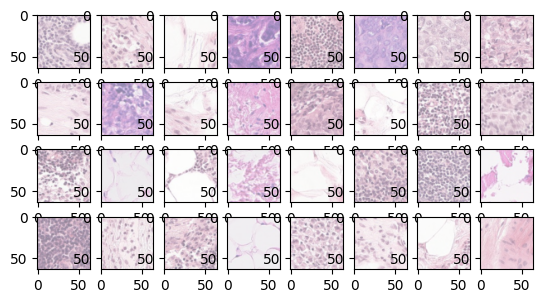

In [ ]:
for i in range(32):
  ax = plt.subplot(4, 8, i+1)
  plt.imshow(train_set[i].permute(1, 2, 0)*0.5 +0.5)
plt.subplots_adjust(hspace=-0.6)

In [ ]:
''' building a deep GAN '''

' building a deep GAN '

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
Discriminator = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False), nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False), nn.Sigmoid(), nn.Flatten()
).to(device)

Generator = nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False), nn.Tanh()
).to(device)

loss_fn=nn.BCELoss()
lr = 0.0002
optimG = torch.optim.Adam(Generator.parameters(), lr = lr, betas=(0.5, 0.999))
optimD = torch.optim.Adam(Discriminator.parameters(), lr = lr, betas=(0.5, 0.999))

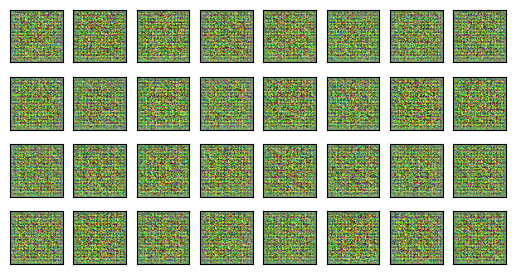

In [ ]:
''' train the GAN '''
def test_epoch():
  noise = torch.randn(32, 100, 1, 1).to(device=device)
  fake_samples = Generator(noise).cpu().detach()
  for i in range(32):
    ax = plt.subplot(4, 8, i+1)
    img_ = (fake_samples.cpu().detach()[i]/2+0.5).permute(1, 2, 0)
    plt.imshow(img_)
    plt.xticks([])
    plt.yticks([])
  plt.subplots_adjust(hspace=-0.6)
  plt.show()
test_epoch()

In [ ]:
real_labels=torch.ones((batch_size, 1)).to(device)
fake_labels=torch.zeros((batch_size, 1)).to(device)

In [ ]:
def train_Discriminator_on_real(real_samples):
    real_samples=real_samples.to(device)
    preds=Discriminator(real_samples)
    labels=torch.ones((real_samples.shape[0],1)).to(device)
    loss_D=loss_fn(preds,labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

def train_Discriminator_on_fake():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=Generator(noise)
    preds=Discriminator(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D

def train_Generator():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=Generator(noise)
    preds=Discriminator(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G

In [ ]:
for i in range(10):
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_dataloader):
      loss_D=train_Discriminator_on_real(real_samples)
      dloss+=loss_D
      loss_D=train_Discriminator_on_fake()
      dloss+=loss_D
      loss_G=train_Generator()
      gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n
    print(f"epoch {i+1}, dloss: {dloss}, gloss {gloss}")

epoch 1, dloss: 0.24329206347465515, gloss 7.378721237182617
epoch 2, dloss: 0.2665248215198517, gloss 7.814659595489502
epoch 3, dloss: 0.2607436180114746, gloss 8.376237869262695
epoch 4, dloss: 0.2817748486995697, gloss 8.33434009552002
epoch 5, dloss: 0.2821694314479828, gloss 7.715625286102295
epoch 6, dloss: 0.269386351108551, gloss 7.768743515014648
epoch 7, dloss: 0.28420862555503845, gloss 7.439437389373779
epoch 8, dloss: 0.2799314558506012, gloss 7.334494590759277
epoch 9, dloss: 0.28095030784606934, gloss 7.09074592590332
epoch 10, dloss: 0.28835996985435486, gloss 6.934658050537109


In [ ]:
# Export to TorchScript
scripted = torch.jit.script(Generator)
scripted.save('cancer_gen.pt')

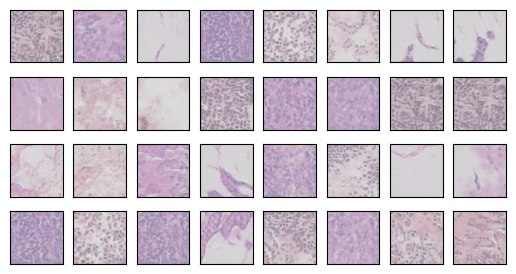

In [ ]:
new_G=torch.jit.load('cancer_gen.pt',
map_location=device)
new_G.eval()
noise=torch.randn(32,100,1,1).to(device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake_samples.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show()